In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from celluloid import Camera
from IPython.display import Audio
import librosa
import torch
from pathlib import Path
from Models.vae import VAEDeep
from datasets import DisentanglementDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from utils import get_bin_index,get_mutual_information
from Metrics.mig import mig
from Metrics.jemmig import jemmig
from Metrics.dci import dci
from Metrics.sap import sap
from Metrics.dcimig import dcimig
from Metrics.modularity import modularity

In [3]:
file_path = Path("/net/projects/scratch/summer/valid_until_31_January_2024/ybrima/data/learning/SyncSpeech/dataset_16k.npz")

dataset = DisentanglementDataset(file_path)

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [5]:
num_models = 1

latent_dim = 8

x_batch, x_spec_batch, y_batch, frequency_batch, amplitude_batch = next(iter(train_loader))

CLASSES  =  dataset.CLASSES
# x_batch, x_spec_batch, y_batch, frequency, amplitude = next(iter(train_loader))

input_shape = x_spec_batch.shape

sr = dataset.sr
hop_length = 512

idx =  np.random.randint(0, x_spec_batch.shape[0])

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model_list = ['./Exports/vae2deep_8.pth', './Exports/betavae2deep_8.pth','./Exports/btcvae2deep_8.pth', './Exports/factorvae2deep_8.pth']

In [8]:
def visualize_vae_reconstruction(model_path, device, latent_dim, input_shape, x_spec_batch, sr, hop_length, idx, CLASSES, amplitude_batch, frequency_batch, save=False, filename="VAE"):
    # Instantiate VAE model
    vae_model = VAEDeep(latent_dim, input_shape).to(device)
    
    # Load pre-trained weights
    state_dict = torch.load(model_path)
    vae_model.load_state_dict(state_dict)

    # Run inference
    with torch.inference_mode():
        x_hat, z_mean, z_logvar = vae_model(x_spec_batch.to(device))

    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

    # Extract mel specs
    mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
    mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

    # Waveforms
    waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
    librosa.display.waveshow(waveform[:100], sr=sr, color='b', ax=axs[0, 0], alpha=0.5)
    axs[0, 0].set_xlabel('Time(s)')
    axs[0, 0].set_ylabel('Amplitude')
    axs[0, 0].set_title('Time domain', fontsize=12)

    waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
    librosa.display.waveshow(waveform_recon[:100], sr=sr, color='b', ax=axs[1, 0], alpha=0.5)
    axs[1, 0].set_xlabel('Time(s)')
    axs[1, 0].set_ylabel('Amplitude')

    # Fourier Transforms
    ft = np.fft.fft(waveform)
    axs[0, 1].plot(np.abs(ft)[:len(ft)//2])
    axs[0, 1].set_xlabel('Frequency')
    axs[0, 1].set_ylabel('Magnitude')
    axs[0, 1].set_title('Fourier Transform', fontsize=12)

    ft_recon = np.fft.fft(waveform_recon)
    axs[1, 1].plot(np.abs(ft_recon)[:len(ft_recon)//2])
    axs[1, 1].set_xlabel('Frequency')
    axs[1, 1].set_ylabel('Magnitude')

    # Mel spectrograms
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                             y_axis='mel', x_axis='s', sr=sr,
                             hop_length=hop_length, ax=axs[0, 2])
    axs[0, 2].set_title('Mel spectrogram', fontsize=12)

    librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                             y_axis='mel', x_axis='s', sr=sr,
                             hop_length=hop_length, ax=axs[1, 2])

    # Figure title
    fig.suptitle(f'{filename} Original (top) vs. Reconstructed (bottom) --Waveform {CLASSES[y_batch[idx]].capitalize()} --amplitude {np.round(amplitude_batch[idx].item(), 2)}dB --frequency {np.round(frequency_batch[idx].item(), 2)}Hz', fontsize=16)

    # Save the figure
    plt.tight_layout()
    if save:
        plt.savefig(f'./Figures/Original_vs_Reconstructed_{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()


def generate_and_visualize_samples(model_path, device, latent_dim, input_shape, sr, hop_length, save=False, filename="VAE"):
    
    # Instantiate VAE model
    vae = VAEDeep(latent_dim, input_shape).to(device)
    
    # Load pre-trained weights
    state_dict = torch.load(model_path)
    vae.load_state_dict(state_dict)
    # Generate random samples from the latent space
    num_samples = 100  # Number of sounds to generate
    latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

    # Decode the latent samples to generate new sounds
    with torch.no_grad():
        vae.eval()
        generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

    # Create figure and axes
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))

    # Randomly select an index for visualization
    idx = np.random.randint(len(generated_mel_spectrograms))
    mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
    waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

    # Waveform
    librosa.display.waveshow(waveform[:100], sr=sr, ax=axs[0], alpha=0.5, color='b')
    axs[0].set_title('Waveform')
    axs[0].set_xlabel('Time(s)')
    axs[0].set_ylabel('Amplitude')

    # Fourier Transform
    ft = np.fft.fft(waveform)
    axs[1].plot(np.abs(ft)[:len(ft)//2])
    axs[1].set_title('Fourier Transform')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Magnitude')

    # Mel Spectrogram
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                             y_axis='mel', x_axis='s', sr=sr,
                             hop_length=hop_length, ax=axs[2])
    axs[2].set_title('Mel Spectrogram')

    fig.suptitle(f'{filename} Generated Sample', fontsize=16)
    plt.tight_layout()

    if save:
        # Save the figure
        plt.savefig(f'./Figures/Generated_sample_{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()


/tmp/ipykernel_709834/3922318876.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


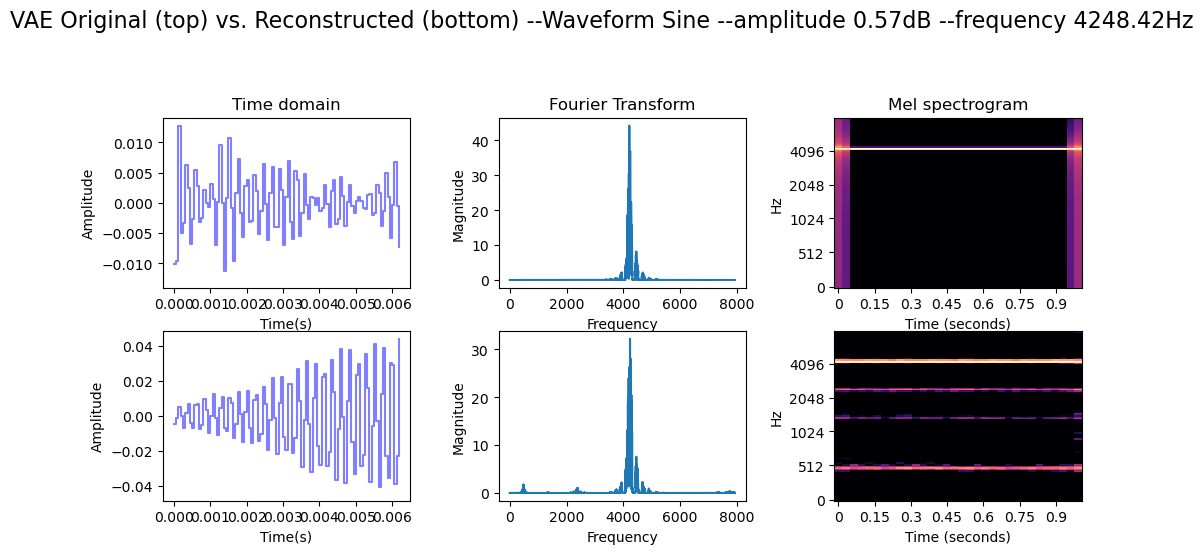

In [168]:
visualize_vae_reconstruction(model_list[0], device, latent_dim, input_shape, x_spec_batch, sr, hop_length, idx, CLASSES, amplitude_batch, frequency_batch, save=True, filename="VAE")

/tmp/ipykernel_709834/3922318876.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


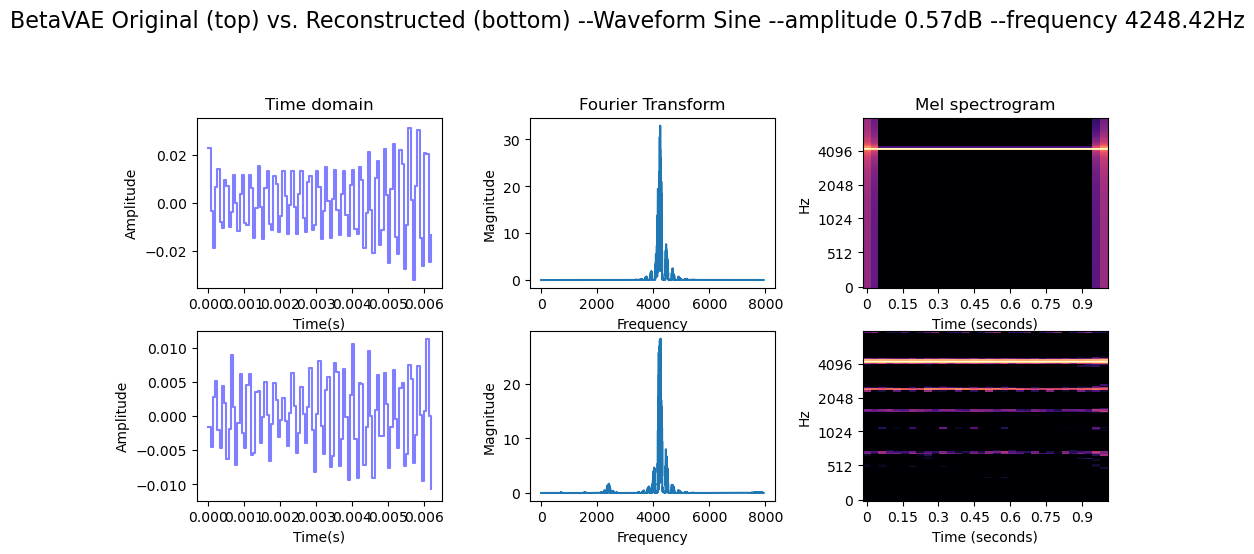

In [10]:
visualize_vae_reconstruction(model_list[1], device, latent_dim, input_shape, x_spec_batch, sr, hop_length, idx, CLASSES, amplitude_batch, frequency_batch, save=True, filename="BetaVAE")

/tmp/ipykernel_709834/3922318876.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


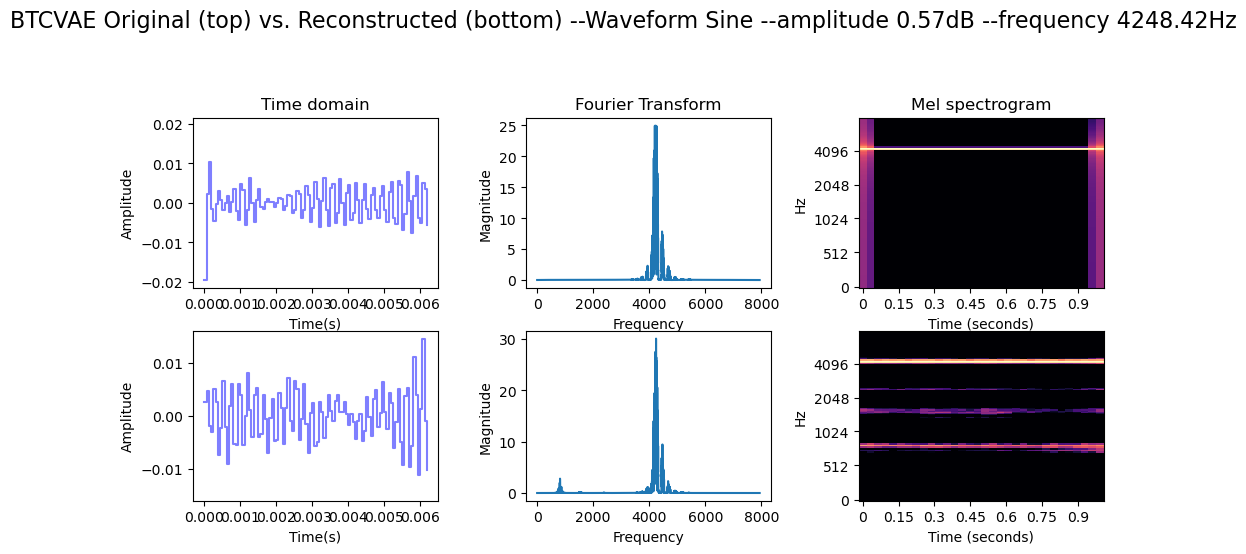

In [11]:
visualize_vae_reconstruction(model_list[2], device, latent_dim, input_shape, x_spec_batch, sr, hop_length, idx, CLASSES, amplitude_batch, frequency_batch, save=True, filename="BTCVAE")

/tmp/ipykernel_709834/3922318876.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


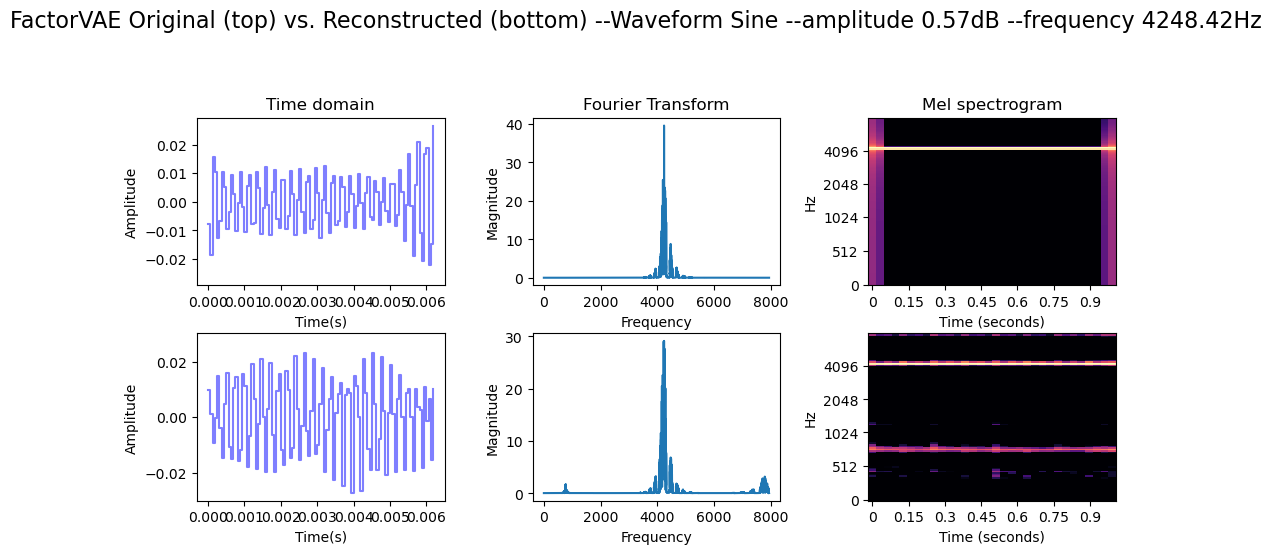

In [12]:
visualize_vae_reconstruction(model_list[3], device, latent_dim, input_shape, x_spec_batch, sr, hop_length, idx, CLASSES, amplitude_batch, frequency_batch, save=True, filename="FactorVAE")

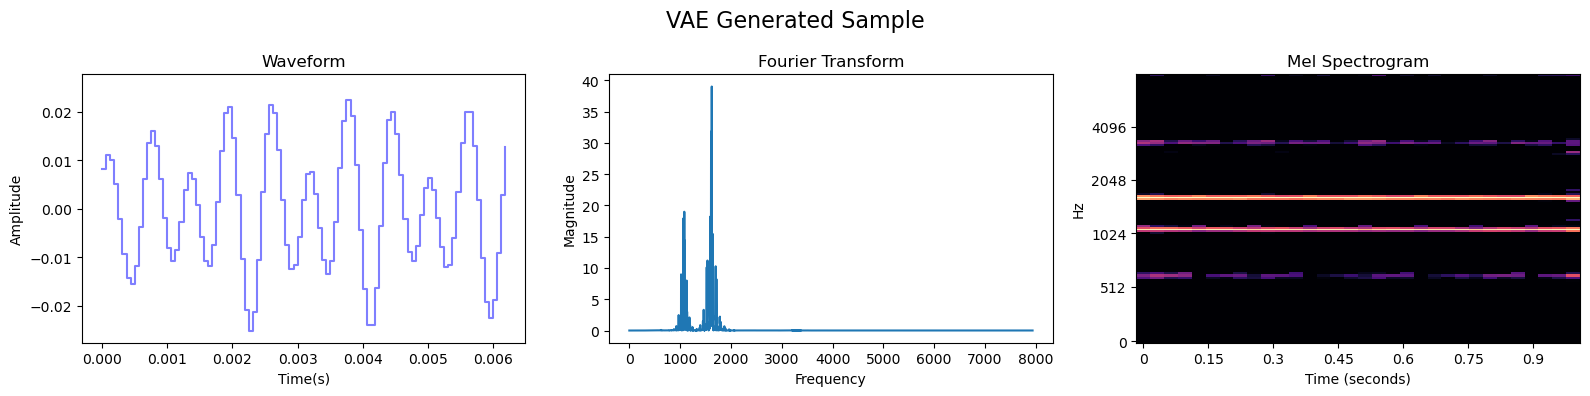

In [19]:
generate_and_visualize_samples(model_list[0], device, latent_dim, input_shape, sr, hop_length, save=True, filename="VAE")

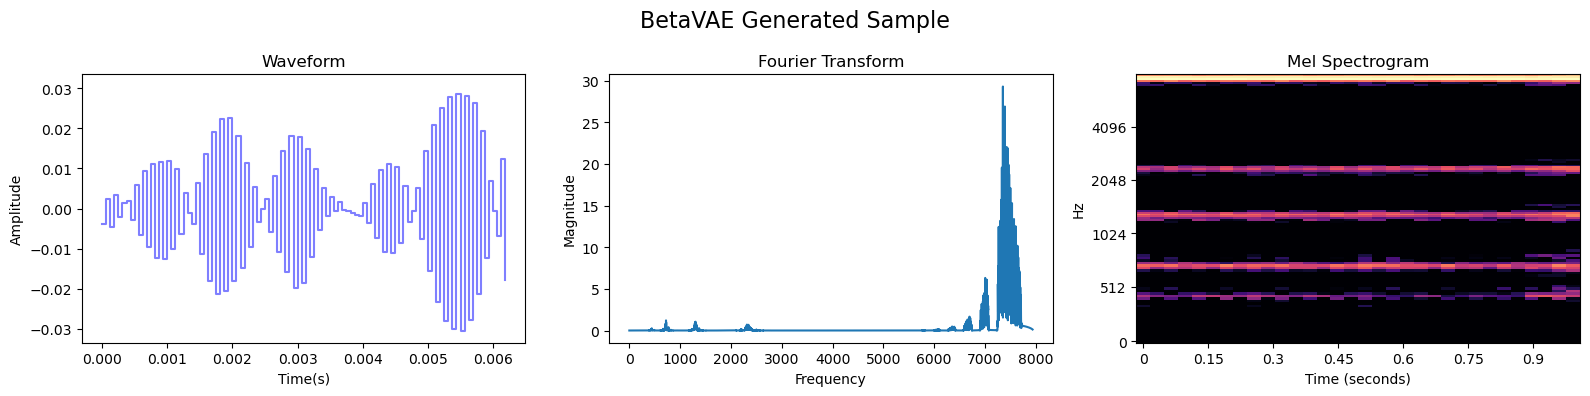

In [24]:
generate_and_visualize_samples(model_list[1], device, latent_dim, input_shape, sr, hop_length, save=True, filename="BetaVAE")

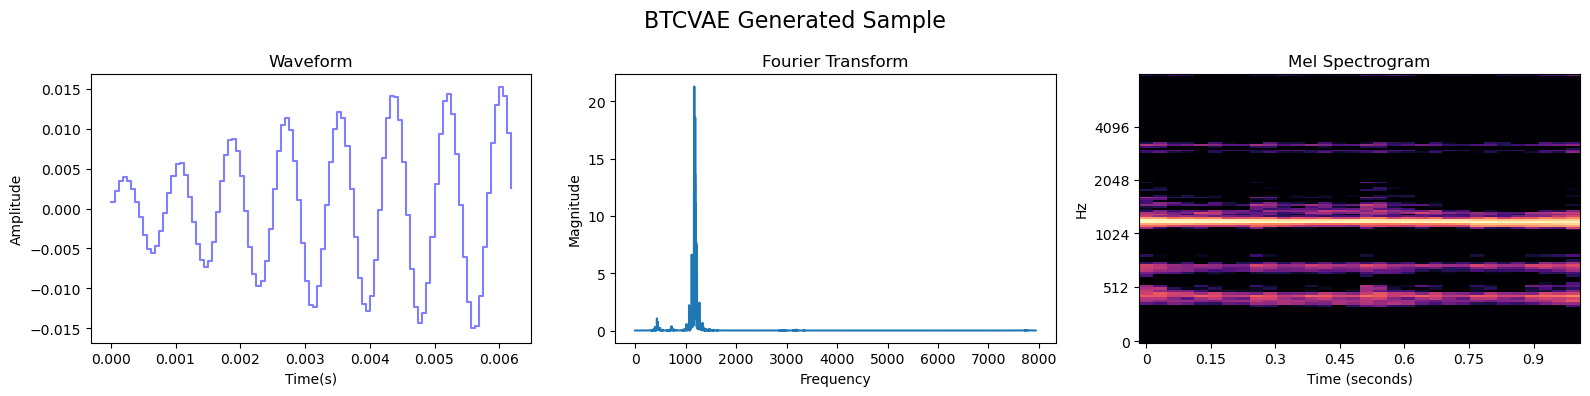

In [28]:
generate_and_visualize_samples(model_list[2], device, latent_dim, input_shape, sr, hop_length, save=True, filename="BTCVAE")

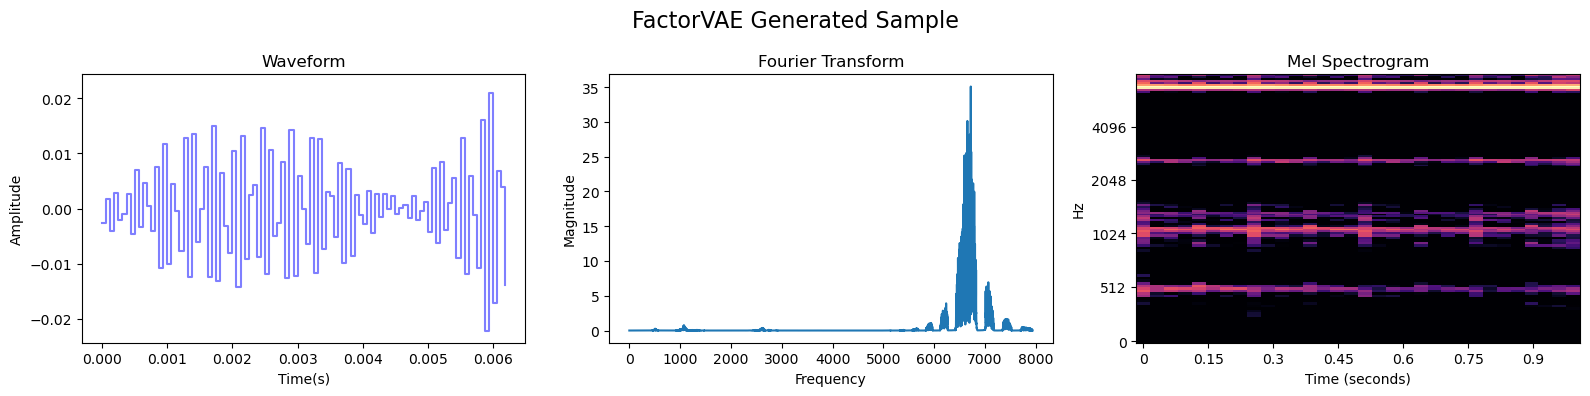

In [30]:
generate_and_visualize_samples(model_list[3], device, latent_dim, input_shape, sr, hop_length, save=True, filename="FactorVAE")

In [119]:
def vae_inference(model_path, latent_dim, input_shape, device, x_spec_batch, sr, hop_length, save=False, filename="VAE", num_samples=10):
    # Instantiate VAE model
    vae_model = VAEDeep(latent_dim, input_shape).to(device)

    # Load pre-trained weights
    state_dict = torch.load(model_path)
    vae_model.load_state_dict(state_dict)

    

    # Run inference
    with torch.inference_mode():
        x_hat, z_mean, z_logvar = vae_model(x_spec_batch[s_idx].unsqueeze(0).to(device))
        z = vae_model.reparameterize(z_mean, z_logvar)

    latent_values = torch.linspace(-3, 3, num_samples)
    z = z.detach().cpu()

    fig, axs = plt.subplots(latent_dim, num_samples, figsize=(12, 12), sharex=True, sharey=True)
    for i in range(latent_dim):
        for j in range(num_samples):
            z[0, i] = latent_values[j]
            with torch.inference_mode():
                x_hat = vae_model.decode(z.to(device))
            mel_spec = x_hat.squeeze().detach().cpu().numpy()
            librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), ax=axs[i, j], y_axis='mel', sr=sr, hop_length=hop_length)
            if j == 0:
                axs[i, j].set_ylabel(fr'$Z_{i+1}$', fontsize=12)

    fig.suptitle(f'{filename} Latent Space Interpolation [-3,3,10] --Waveform {CLASSES[y_batch[idx]].capitalize()} --Amplitude {np.round(amplitude_batch[idx].item(), 2)}dB --Frequency {np.round(frequency_batch[idx].item(), 2)}Hz', fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig(f'./Figures/{filename}_Latent_Space_Interpolation.png', dpi=300, bbox_inches='tight')
    plt.show()

In [120]:
s_idx  = np.random.randint(0, x_spec_batch.shape[0])

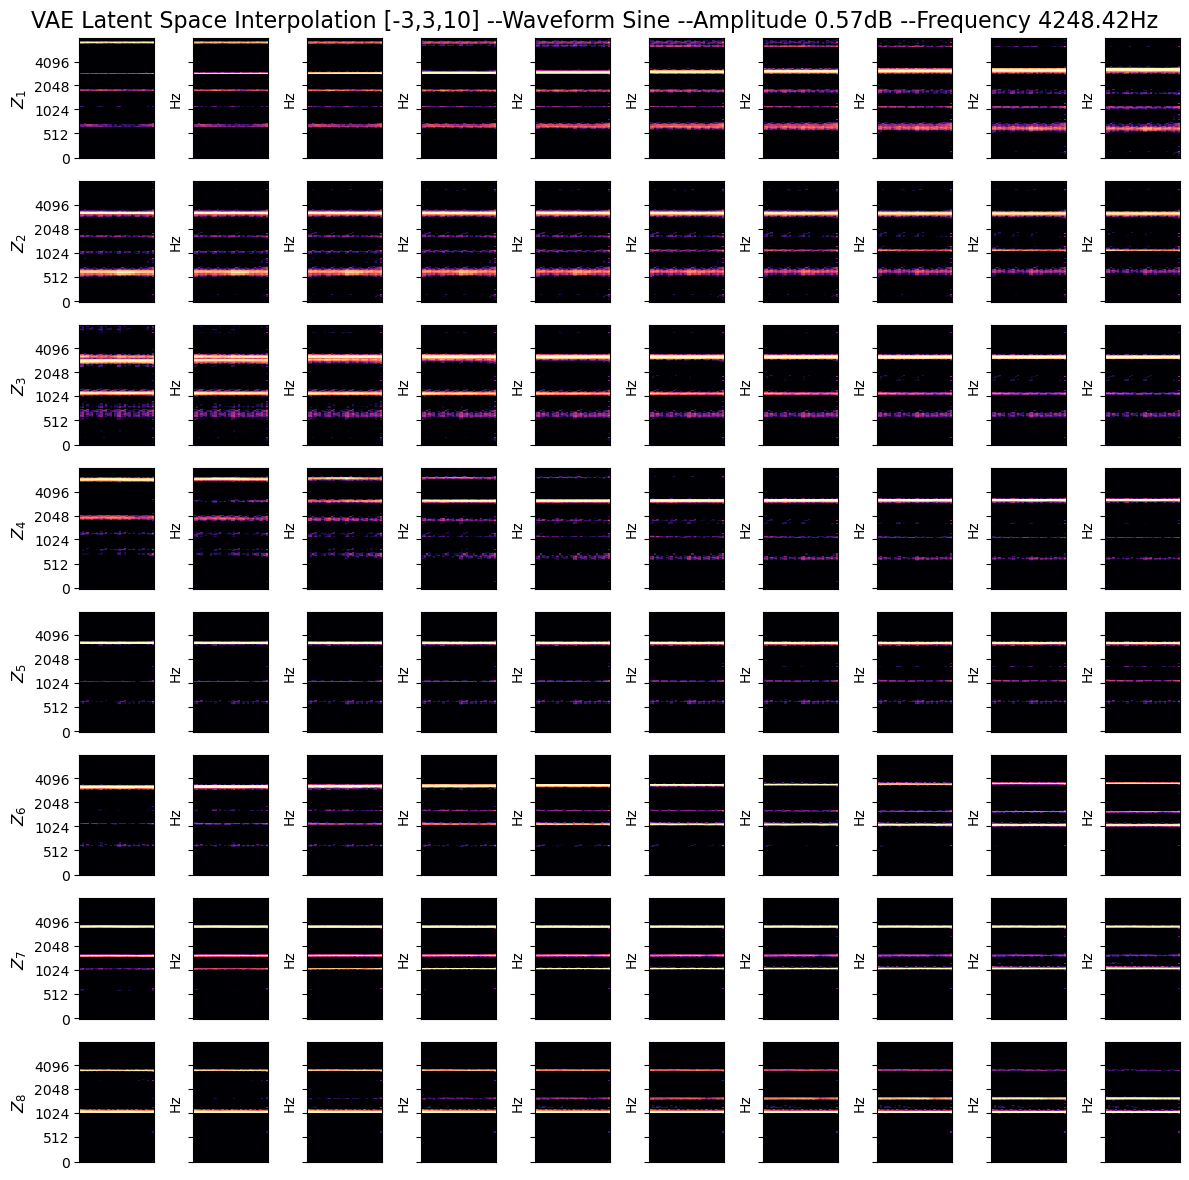

In [121]:
model_path = model_list[0]
vae_inference(model_path, latent_dim, input_shape, device, x_spec_batch, sr, hop_length, save=True, filename="VAE", num_samples=10)

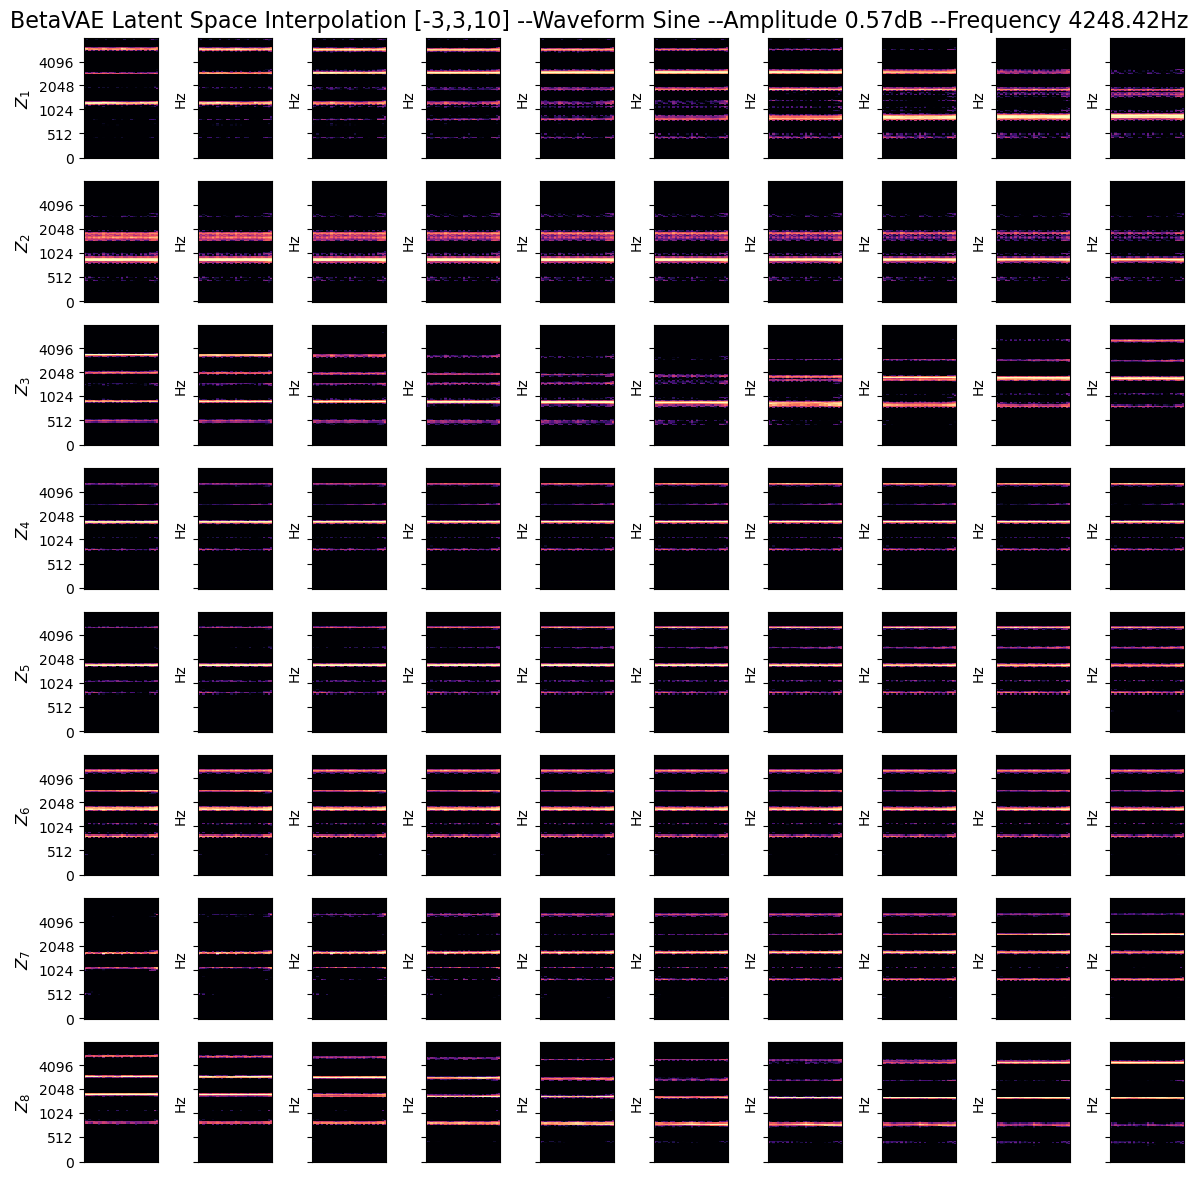

In [122]:
model_path = model_list[1]
vae_inference(model_path, latent_dim, input_shape, device, x_spec_batch, sr, hop_length, save=True, filename="BetaVAE", num_samples=10)

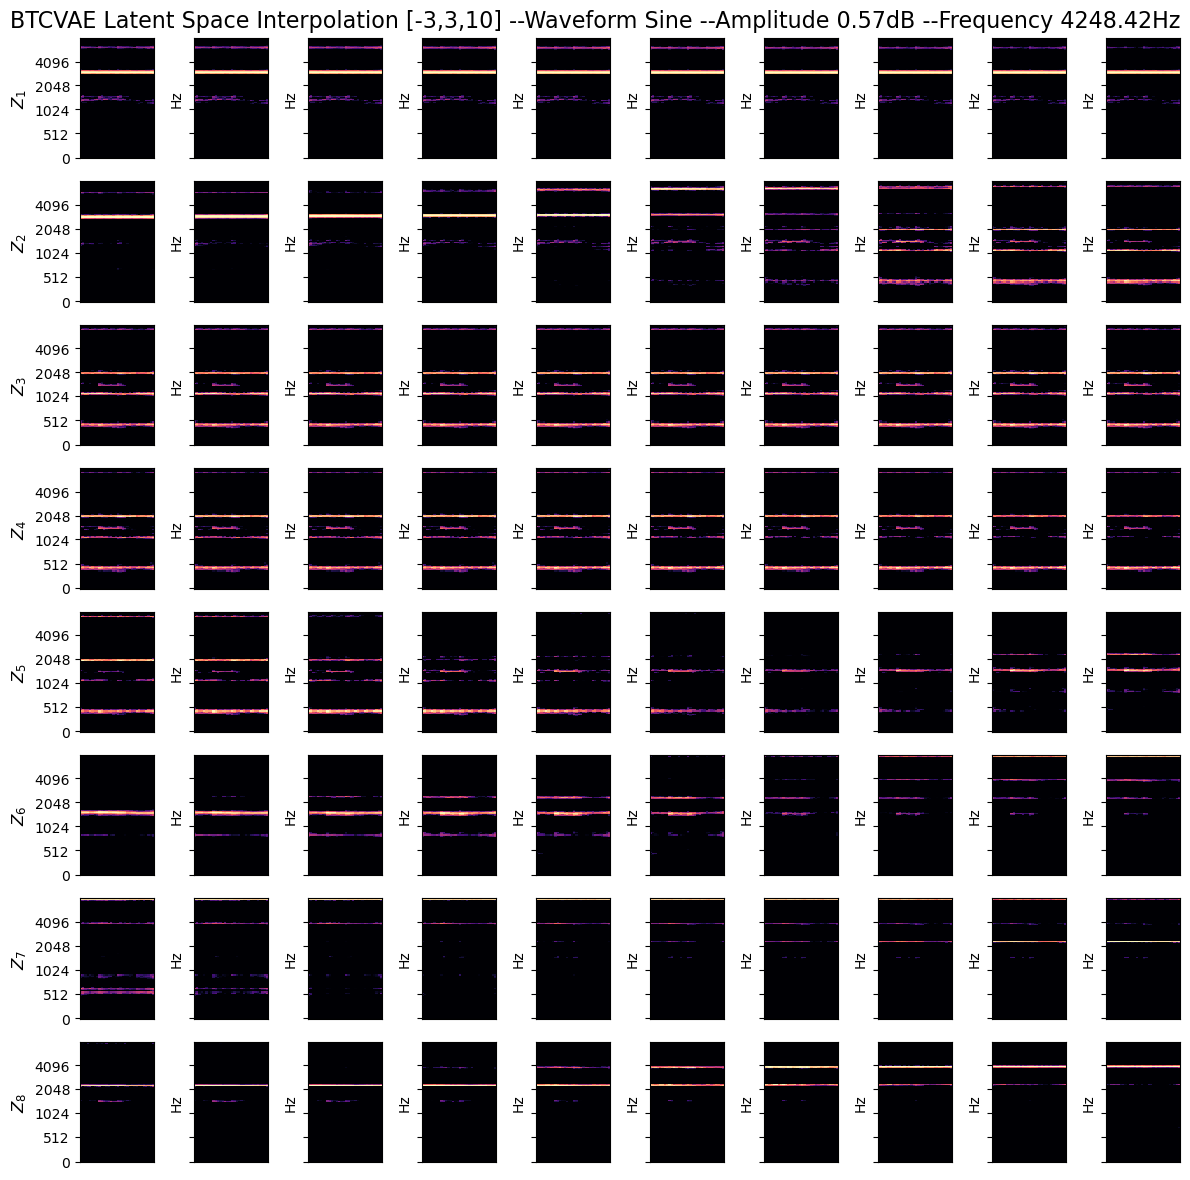

In [123]:
model_path = model_list[2]
vae_inference(model_path, latent_dim, input_shape, device, x_spec_batch, sr, hop_length, save=True, filename="BTCVAE", num_samples=10)

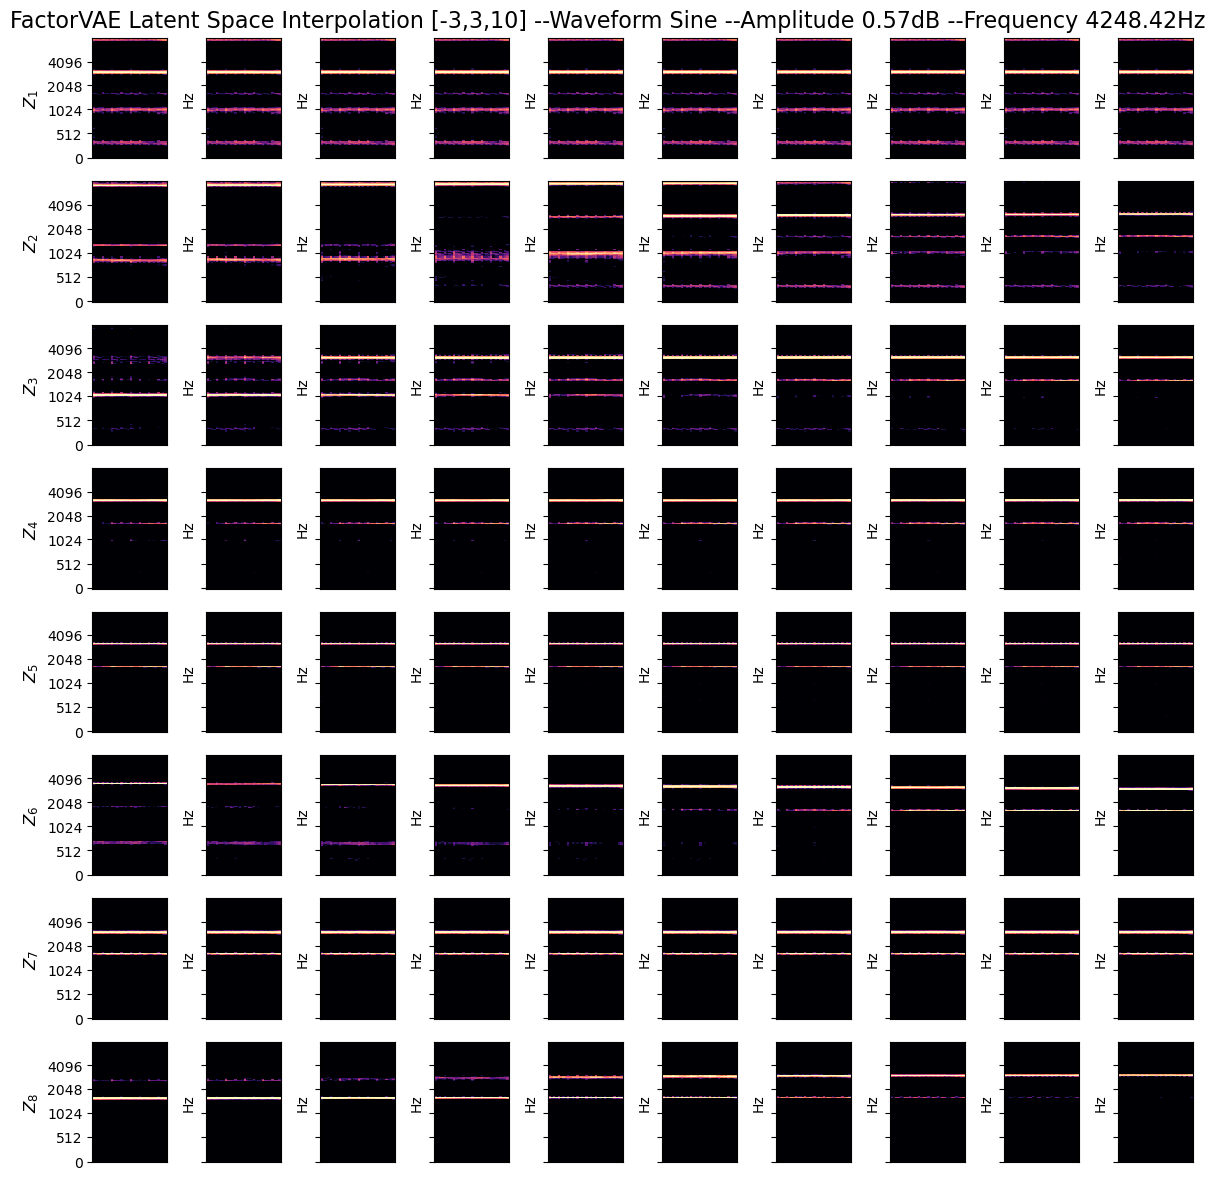

In [127]:
model_path = model_list[3]
vae_inference(model_path, latent_dim, input_shape, device, x_spec_batch, sr, hop_length, save=False, filename="FactorVAE", num_samples=10)

In [134]:
import os 

csv_directory = './Data/'
# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each CSV file
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(csv_directory, csv_file))

    # Extract time period or use a placeholder identifier (e.g., file name)
    time_period = os.path.splitext(csv_file)[0]

    # Add time_period column to the DataFrame
    df['time_period'] = time_period

    # Append DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into a single panel DataFrame
panel_df = pd.concat(dfs, ignore_index=True)

# Display the panel DataFrame
# print(panel_df)
mean_df = panel_df.groupby('model').mean().reset_index()
print(mean_df)


TypeError: agg function failed [how->mean,dtype->object]

In [153]:
file_list = Path("./Data/").glob("*.csv")
n = 0
history = { 
    "vae_history": { 
        "mig" : [],
        "jemmig" : [],
        "dcimig" : [],
        "modularity" : [],
        "sap" : []
    },
    "betavae_history": { 
        "mig" : [],
        "jemmig" : [],
        "dcimig" : [],
        "modularity" : [],
        "sap" : []
    },
    "btcvae_history": { 
        "mig" : [],
        "jemmig" : [],
        "dcimig" : [],
        "modularity" : [],
        "sap" : []
    },
    "factorvae_history": { 
        "mig" : [],
        "jemmig" : [],
        "dcimig" : [],
        "modularity" : [],
        "sap" : []
    }
}


for f in file_list:
    df = pd.read_csv(f)
    history["vae_history"]["mig"].append(df.iloc[0,1])
    history["vae_history"]["jemmig"].append(df.iloc[0,2])
    history["vae_history"]["dcimig"].append(df.iloc[0,3])
    history["vae_history"]["modularity"].append(df.iloc[0,4])
    history["vae_history"]["sap"].append(df.iloc[0,5])
    # betavae history
    history["betavae_history"]["mig"].append(df.iloc[1,1])
    history["betavae_history"]["jemmig"].append(df.iloc[1,2])
    history["betavae_history"]["dcimig"].append(df.iloc[1,3])
    history["betavae_history"]["modularity"].append(df.iloc[1,4])
    history["betavae_history"]["sap"].append(df.iloc[1,5])
    # btcvae history
    history["btcvae_history"]["mig"].append(df.iloc[2,1])
    history["btcvae_history"]["jemmig"].append(df.iloc[2,2])
    history["btcvae_history"]["dcimig"].append(df.iloc[2,3])
    history["btcvae_history"]["modularity"].append(df.iloc[2,4])
    history["btcvae_history"]["sap"].append(df.iloc[2,5])
    # factorvae history
    history["factorvae_history"]["mig"].append(df.iloc[3,1])
    history["factorvae_history"]["jemmig"].append(df.iloc[3,2])
    history["factorvae_history"]["dcimig"].append(df.iloc[3,3])
    history["factorvae_history"]["modularity"].append(df.iloc[3,4])
    history["factorvae_history"]["sap"].append(df.iloc[3,5])

In [167]:
df = pd.DataFrame(history["factorvae_history"])
# print(df)
# return the mean and std (in scientific notation) side by side
# print(df.mean())
# print(df.std())

mean_values = df.mean()
std_values = df.std()

# Create a LaTeX-formatted table with mean ± std
latex_table = pd.DataFrame({
    'Mean ± Std': mean_values.round(3).astype(str) + ' $\\pm$ ' + std_values.round(2).apply(lambda x: f'{x:.2e}')
}).to_latex(escape=False, index=False)

# Print the LaTeX-formatted table
print(latex_table)

\begin{tabular}{l}
\toprule
Mean ± Std \\
\midrule
0.118 $\pm$ 0.00e+00 \\
0.126 $\pm$ 0.00e+00 \\
0.003 $\pm$ 0.00e+00 \\
0.762 $\pm$ 1.00e-02 \\
0.035 $\pm$ 0.00e+00 \\
\bottomrule
\end{tabular}



In [152]:
# Create a LaTeX-formatted table
latex_table = pd.DataFrame({
    'Mean': mean_values,
    'Std': std_values.apply(lambda x: f'({x:.2e})')  # Wrap std in parentheses
}).to_latex(escape=False, float_format="{:.2e}".format)

# Print the LaTeX-formatted table
print(latex_table)

\begin{tabular}{lrl}
\toprule
 & Mean & Std \\
\midrule
mig & 2.80e-01 & (7.17e-04) \\
jemmig & 3.00e-01 & (7.22e-04) \\
dcimig & 4.51e-03 & (2.51e-04) \\
modularity & 6.51e-01 & (3.08e-02) \\
sap & 4.48e-02 & (4.80e-05) \\
\bottomrule
\end{tabular}

